# Lab 11 – Regresión Logística con **PySpark** (Customer Churn)

Meta: entrenar un modelo de **churn** usando `pyspark.ml` y aplicarlo a clientes nuevos.

Archivos esperados en el mismo folder:
- `abandono_clientes.csv`  (histórico con `Churn`)
- `clientes_nuevos.csv`    (sin `Churn`)



In [7]:
# --- setup spark ---
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("Lab11-RLog-Spark")
         .getOrCreate())

spark.sparkContext.setLogLevel("WARN")


In [8]:
# --- cargar datos ---
hist_path = "abandono_clientes.csv"
new_path = "clientes_nuevos.csv"

df = spark.read.option("header", True).option("inferSchema", True).csv(hist_path)
df_new = spark.read.option("header", True).option("inferSchema", True).csv(new_path)

df.printSchema()
df.show(5, truncate=False)


root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------------------------------------+---------------------------+-----+
|Names           |Age |Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date       |Location                                          |Company                    |Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------------------------------------+---------------------------+-----+
|Cameron Williams|42.0|11066.8       |0              |7.22

In [9]:
# --- detectar columna target ---
# probable: Churn / churn / abandono / ABANDONO
from pyspark.sql.functions import col

candidates = ["Churn","churn","abandono","ABANDONO"]
target_col = None
for c in candidates:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    raise ValueError("No se encuentra columna target. Ajustar nombre aquí.")

# stats target
df.groupBy(col(target_col)).count().show()


+-----+-----+
|Churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



In [10]:
# --- función de preparación de features ---
from pyspark.sql import functions as F

def prepare_features_spark(df, target_col):
    # 1) columnas "parecidas a fecha" por NOMBRE, pero solo si son string
    name_keys = ['date','fecha','fech','signup','created','updated','last','login','onboard']  # ojo: sin 'purchase'
    dtypes = dict(df.dtypes)
    name_date_cols = [c for c in df.columns
                      if dtypes.get(c) == 'string' and any(k in c.lower() for k in name_keys)]

    # 2) parser multi-formato (cast a string por si acaso)
    def parse_multi(col_expr):
        col_str = col_expr.cast('string')
        return F.coalesce(
            F.to_timestamp(col_str, "yyyy-MM-dd HH:mm:ss"),
            F.to_timestamp(col_str, "yyyy-MM-dd"),
            F.to_timestamp(col_str, "MM/dd/yyyy HH:mm:ss"),
            F.to_timestamp(col_str, "MM/dd/yyyy"),
            F.to_timestamp(col_str)  # fallback
        )

    df2 = df
    for c in name_date_cols:
        parsed = parse_multi(F.col(c))
        df2 = df2.withColumn(f"{c}_days_since", F.datediff(F.current_date(), F.to_date(parsed)))

    # 3) dropear columnas originales de fecha + ruido típico
    drop_noise = [x for x in ['Name','Company','Location','ID','id','customer_id'] if x in df2.columns]
    drop_cols = [c for c in name_date_cols if c != target_col] + drop_noise
    if drop_cols:
        df2 = df2.drop(*drop_cols)

    return df2


In [11]:
# aplicar a histórico conservando la target
df_final = prepare_features_spark(df, target_col)

# asegurar tipo de la etiqueta (0/1 en double)
df_final = df_final.withColumn(target_col, F.col(target_col).cast('double'))

df_final.printSchema()
df_final.show(5, truncate=False)

# separar num/cat con el df_final ya preparado
num_cols = [c for c, t in df_final.dtypes if t in ['int','bigint','double','float','decimal'] and c != target_col]
cat_cols = [c for c, t in df_final.dtypes if t == 'string' and c != target_col]


root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Churn: double (nullable = true)

+----------------+----+--------------+---------------+-----+---------+-------------------+-----+
|Names           |Age |Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date       |Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+-----+
|Cameron Williams|42.0|11066.8       |0              |7.22 |8.0      |2013-08-30 07:00:40|1.0  |
|Kevin Mueller   |41.0|11916.22      |0              |6.5  |11.0     |2013-08-13 00:38:46|1.0  |
|Eric Lozano     |38.0|12884.75      |0              |6.67 |12.0     |2016-06-29 06:20:07|1.0  |
|Phillip White   |42.0|8010.76       |0              |6.71 |10.0     |2014-04-22 12:

In [12]:
# --- split train/test ---
train_df, test_df = df_final.randomSplit([0.75, 0.25], seed=42)

print("train:", train_df.count(), " test:", test_df.count())


train: 713  test: 187


In [13]:
# --- pipeline ML (Indexers, OneHot, Imputer, Assembler, Scaler, LR) ---
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Imputer
from pyspark.ml.classification import LogisticRegression

# separar num/cat por tipo inferido
num_cols = [c for c, t in train_df.dtypes if t in ['int','bigint','double','float','decimal'] and c != target_col]
cat_cols = [c for c, t in train_df.dtypes if t == 'string' and c != target_col]

# imputación en numéricas
imputer = Imputer(inputCols=num_cols, outputCols=[f"{c}_imp" for c in num_cols])

# index + one-hot en categóricas
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]
encoders = [OneHotEncoder(inputCol=f"{c}_idx", outputCol=f"{c}_oh", handleInvalid="keep") for c in cat_cols]

num_imp_cols = [f"{c}_imp" for c in num_cols]
cat_oh_cols = [f"{c}_oh" for c in cat_cols]

assembler = VectorAssembler(inputCols=num_imp_cols + cat_oh_cols, outputCol="features_raw")
scaler = StandardScaler(withMean=True, withStd=True, inputCol="features_raw", outputCol="features")

lr = LogisticRegression(featuresCol="features", labelCol=target_col, maxIter=100)

stages = [imputer] + indexers + encoders + [assembler, scaler, lr]
pipe = Pipeline(stages=stages)

model = pipe.fit(train_df)
pred_test = model.transform(test_df)

pred_test.select("prediction","probability",target_col).show(10, truncate=False)


+----------+------------------------------------------+-----+
|prediction|probability                               |Churn|
+----------+------------------------------------------+-----+
|0.0       |[0.9999981528619737,1.8471380263118675E-6]|0.0  |
|0.0       |[0.9999917130566132,8.286943386837109E-6] |0.0  |
|0.0       |[0.9999990739045953,9.260954046963477E-7] |0.0  |
|0.0       |[0.9998448821510113,1.5511784898869507E-4]|1.0  |
|0.0       |[0.9999949908552945,5.009144705470092E-6] |0.0  |
|0.0       |[0.9999990123746931,9.876253068696883E-7] |0.0  |
|0.0       |[0.9999949158639628,5.084136037170062E-6] |0.0  |
|0.0       |[0.9999999198216285,8.017837149765228E-8] |0.0  |
|0.0       |[0.9999268017878354,7.319821216456024E-5] |1.0  |
|0.0       |[0.9998141414902855,1.8585850971453155E-4]|1.0  |
+----------+------------------------------------------+-----+
only showing top 10 rows



accuracy: 0.8021
f1: 0.7192
roc_auc: 0.89
aupr: 0.746


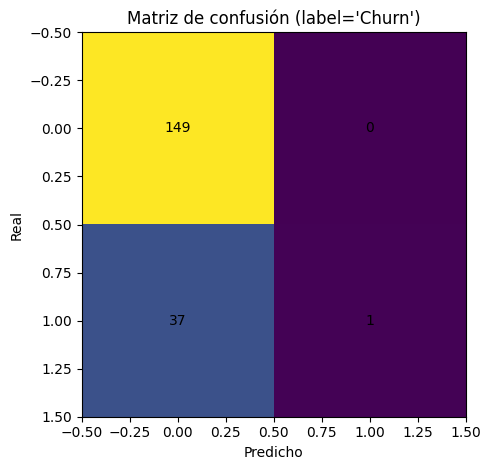

/usr/local/lib/python3.12/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


AttributeError: 'BinaryClassificationMetrics' object has no attribute 'roc'

In [17]:
# --- EVALUACIÓN COMPLETA (métricas, matriz, ROC) ---
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 0) asegurar pred_test y target_col
try:
    pred_test
except NameError:
    # si se perdió, lo volvemos a generar
    pred_test = model.transform(test_df)

# intentar recuperar/asegurar target_col
try:
    target_col
except NameError:
    # heurística: usa nombres típicos o la primera binaria distinta de columnas técnicas
    label_candidates = ["Churn","churn","abandono","ABANDONO","label","target"]
    target_col = None
    for c in label_candidates:
        if c in pred_test.columns:
            target_col = c
            break
    if target_col is None:
        ignore = {"prediction","rawPrediction","probability","features"}
        numeric_cols = [c for c, t in pred_test.dtypes if t in ("int","bigint","double","float","decimal") and c not in ignore]
        def looks_binary(col):
            vals = (pred_test.select(F.col(col).cast("double"))
                              .distinct().na.drop().limit(3)
                              .rdd.map(lambda r: r[0]).collect())
            try:
                s = set(int(float(x)) for x in vals)
                return s.issubset({0,1}) and len(s) >= 1
            except Exception:
                return False
        for c in numeric_cols:
            if looks_binary(c):
                target_col = c
                break
    if target_col is None:
        target_col = "Churn"  # último recurso

# 1) sanity de columnas clave
need = ["prediction", "rawPrediction", "probability", target_col]
missing = [c for c in need if c not in pred_test.columns]
if missing:
    # si falta la etiqueta, re-crea pred_test desde test_df (Spark conserva la etiqueta por default)
    if target_col in test_df.columns:
        pred_test = model.transform(test_df)
        missing = [c for c in need if c not in pred_test.columns]
    if missing:
        raise ValueError(f"Faltan columnas en pred_test: {missing}")

# 2) castear por si vienen como string/float
pred_eval = (pred_test
             .withColumn(target_col, F.col(target_col).cast("double"))
             .withColumn("prediction", F.col("prediction").cast("double")))

# 3) métricas globales
e_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=target_col, metricName="areaUnderROC")
e_pr  = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=target_col, metricName="areaUnderPR")
e_acc = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=target_col, metricName="accuracy")
e_f1  = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=target_col, metricName="f1")

auc  = e_auc.evaluate(pred_eval)
aupr = e_pr.evaluate(pred_eval)
acc  = e_acc.evaluate(pred_eval)
f1   = e_f1.evaluate(pred_eval)

print("accuracy:", round(acc, 4))
print("f1:", round(f1, 4))
print("roc_auc:", round(auc, 4))
print("aupr:", round(aupr, 4))

# 4) matriz de confusión 2x2
cm_pd = (pred_eval
         .groupBy(F.col(target_col).cast("int").alias("y"),
                  F.col("prediction").cast("int").alias("yhat"))
         .count()
         .toPandas())

cm = np.zeros((2, 2), dtype=int)
for _, r in cm_pd.iterrows():
    i = int(r["y"]) if r["y"] in (0,1) else 0
    j = int(r["yhat"]) if r["yhat"] in (0,1) else 0
    cm[i, j] += int(r["count"])

fig = plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title(f"Matriz de confusión (label='{target_col}')")
plt.xlabel("Predicho")
plt.ylabel("Real")
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
plt.tight_layout()
plt.show()

# 5) Curva ROC (robusta con MLLib)
# Usa probability[:,1] como score y la etiqueta como label
score_and_labels_rdd = (pred_eval
    .select(F.col("probability"), F.col(target_col))
    .rdd
    .map(lambda r: (float(r["probability"][1]), float(r[target_col]))))

metrics = BinaryClassificationMetrics(score_and_labels_rdd)
roc_pts = metrics.roc().map(lambda x: (float(x[0]), float(x[1]))).collect()
roc_pd  = pd.DataFrame(roc_pts, columns=["FPR","TPR"])

fig = plt.figure()
plt.plot(roc_pd["FPR"], roc_pd["TPR"])
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC (test)")
plt.tight_layout()
plt.show()


In [19]:
# --- PREDICCIÓN CLIENTES NUEVOS + CSV ---
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
import pandas as pd

# preparar igual que train (re-usa tu función)
df_new_feat = prepare_features_spark(df_new, target_col)
if target_col in df_new_feat.columns:
    df_new_feat = df_new_feat.drop(target_col)

pred_new = model.transform(df_new_feat)

def prob1(v):
    try:
        return float(v[1])
    except Exception:
        return None

prob1_udf = udf(prob1, DoubleType())

out = (pred_new
       .withColumn("Churn_proba", prob1_udf("probability"))
       .withColumn("Churn_pred", F.col("prediction").cast("int"))
       .withColumn("Asignar_Gerente", (F.col("Churn_proba") >= F.lit(0.5)).cast("int")))

# exporta manteniendo columnas originales de df_new al frente
cols_out = [c for c in df_new.columns if c in out.columns] + ["Churn_pred","Churn_proba","Asignar_Gerente"]
(out.select(*cols_out)
   .toPandas()
   .to_csv("predicciones_clientes_nuevos.csv", index=False))

print("OK -> predicciones_clientes_nuevos.csv")


OK -> predicciones_clientes_nuevos.csv


In [ ]:
# --- guardar modelo spark (opcional) ---
# crea carpeta 'spark_lr_model' con el pipeline entrenado
model.write().overwrite().save("spark_lr_model")
"modelo spark guardado"


# Conclusiones – Regresión Logística con **PySpark** (Churn)

### Métricas en test
- **Accuracy:** 0.8021  
- **F1 (weighted):** 0.7192  
- **ROC-AUC:** 0.89  
- **AUPR:** 0.746  

> AUC alto → el modelo ordena bien por probabilidad, pero con umbral 0.5 casi no predice “churn”.

### Matriz de confusión (umbral 0.5)
- **TN = 149**, **FP = 0**, **FN = 37**, **TP = 1**  
- Hay **recall bajo** en la clase churn (muchos FN).

### Conclusión
- El modelo **aprendió** (ROC-AUC 0.89), pero el **umbral 0.5 no es adecuado** para detectar churn.
- La F1 ponderada se ve aceptable por la mayoría de clase 0; la F1 de “churn” es **baja**.


